In [1]:
pip install catboost -qqq

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error as mape
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# set the color palette
sns.set_palette(sns.color_palette('deep'))
sns.set(rc = {'figure.figsize': (10, 5)})
sns.set_style('whitegrid')

## <b><span style='color:#686dec'>1 | Вводная Часть</span></b>

### ▎Ранжирования Книг


Сегодня посмотрим на задачу `ранжирования товаров`. По сути это процесс упорядочивания товаров по определенным критериям. 

Зачем нам это нужно; это влияние на пользовательский опыт:
   - Удобство поиска и фильтрации товаров
   - Индивидуальные рекомендации на основе поведения пользователя 
   - Персонализированные результаты на основе истории покупок и предпочтений (рассмотрим в следующем ноутбуке)

Подход который мы рассмотрим; Эту задачу мы можем решить с помощью машинного обучения. Имея исторические данные о приоритетах пользователей мы можем предсказывать `implicit`/`explicit` метрики оценки товара.

## <b><span style='color:#686dec'>2 | Amazon Best Seller Dataset</span></b>

### ▎Чтение данных

Рассмотрим ранжирование товаров на примере датасета Amazon Top 50 Bestselling Books 2009 – 2019, Датасет содержит 550 книг

`Признаки:` <br>
1. __Name:__ Название книги <br>
1. __Author:__ Автор книги <br>
1. __User Rating:__ Рейтинг <br>
1. __Reviews:__ Количество ревью <br>
1. __Price:__ Стоимость книги <br>
1. __Year:__ Год когда книга попала в бестселлеры <br>
1. __Genre:__ Жанр Fiction или Non-fiction <br>

In [3]:
path = '/kaggle/input/bestseller/bestsellers with categories.csv'
df = pd.read_csv(path)
df.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [4]:
df.shape

(550, 7)

In [5]:
df['Name'].value_counts()
df[df['Name'] == "Oh, the Places You'll Go!"]

,Name,Author,User Rating,Reviews,Price,Year,Genre
245,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2012,Fiction
246,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2013,Fiction
247,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2014,Fiction
248,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2015,Fiction
249,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2016,Fiction
250,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2017,Fiction
251,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2018,Fiction
252,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2019,Fiction


In [6]:
df.drop_duplicates(subset=['Name', 'Author'], inplace=True)
df.shape

(351, 7)

## <b><span style='color:#686dec'>3 | Разведовательный Анализ</span></b>

### ▎Колонки для ранжирования

У нас в датасете две основные колонки которые мы можем использлвать для ранжирования товаров; это explicit и implicit feedback; количество ревьюеров `Reviews` и их совокупная оценка пользователей `User Rating`; эти колонки будут нашими `таргетами` при обучении моделей

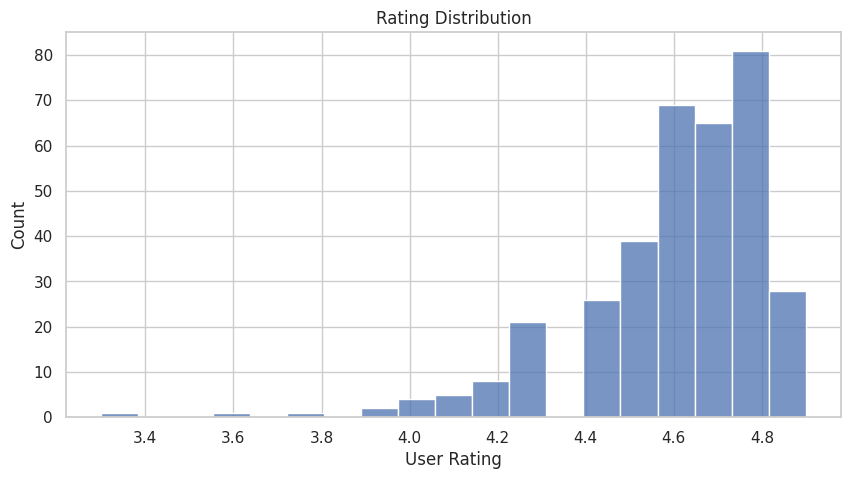

In [7]:
# ratings distribution
plt.title('Rating Distribution')
sns.histplot(x = 'User Rating', data = df);

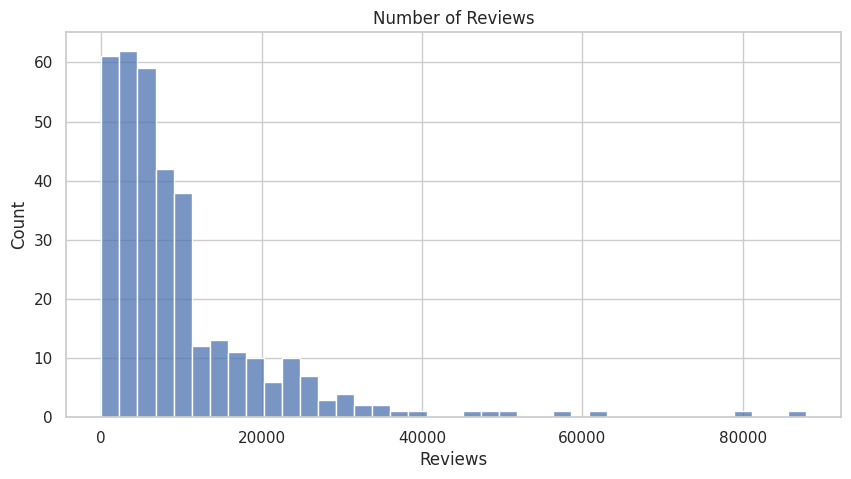

In [8]:
# ratings distribution
plt.title('Number of Reviews')
sns.histplot(x = 'Reviews', data = df);

In [9]:
df['Name Length'] = df['Name'].apply(lambda name: len(name))

In [10]:
train = df[df['Year'] < 2019]
test = df[df['Year'] == 2019]

In [11]:
train.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre,Name Length
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction,29
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction,17
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction,39
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction,22
5,A Dance with Dragons (A Song of Ice and Fire),George R. R. Martin,4.4,12643,11,2011,Fiction,45


## <b><span style='color:#686dec'>4 | Ранжирования Товаров</span></b>

### ▎Модель Предсказания Совокупного Рейтинга Фильма

In [12]:
# Фичи и целевая переменная 
features = ['Name','Author','Price','Genre','Name Length']
target = 'User Rating'

# Для catboost можно указать категориальные фичи и текстовые 
categorical_features = ['Author', 'Genre'] 
text_features = ['Name']

In [13]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [14]:
model = CatBoostRegressor(loss_function='RMSE', 
                          verbose=False)
model.fit(X_train, 
          y_train,
          categorical_features,
          text_features)

preds = model.predict(X_test)
print(f'Mean Absolute Percentage Error (MAPE): {round(mape(y_test, preds) * 100, 2)}')

Mean Absolute Percentage Error (MAPE): 3.21


In [15]:
rating_pred = test.copy()
rating_pred['Pred Rating'] = preds
rating_pred.sort_values(by='Pred Rating', ascending=False, inplace=True)
rating_pred.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre,Name Length,Pred Rating
86,Dog Man: For Whom the Ball Rolls: From the Cre...,Dav Pilkey,4.9,9089,8,2019,Fiction,85,4.872677
85,Dog Man: Fetch-22: From the Creator of Captain...,Dav Pilkey,4.9,12619,8,2019,Fiction,70,4.865559
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction,44,4.785464
155,Harry Potter and the Goblet of Fire: The Illus...,J. K. Rowling,4.9,7758,18,2019,Fiction,87,4.771625
150,Guts,Raina Telgemeier,4.8,5476,7,2019,Non Fiction,4,4.733733


In [16]:
model.feature_importances_

array([44.15442025, 17.23367217, 18.09923482,  2.28755613, 18.22511664])

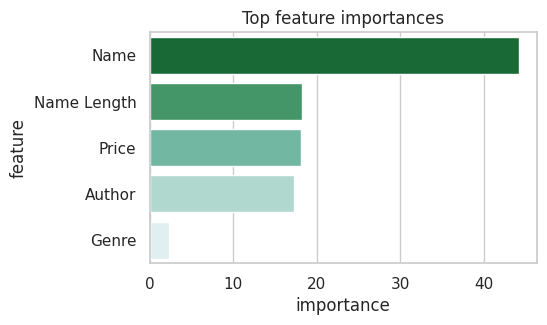

In [17]:
imp_catboost = pd.DataFrame(X_train.columns, 
                            columns = ['feature'])
imp_catboost['importance'] = model.feature_importances_

sns.set_theme(rc={'figure.figsize':(5,3)},style='whitegrid')
ax = sns.barplot(data=imp_catboost.sort_values(by='importance', ascending=False), 
            x='importance', y='feature', palette="BuGn_r")
plt.title('Top feature importances');

### ▎Модель предсказания количества рейтингов

Для второй модели попробуем предсказывать `Reviews`

In [18]:
target = 'Reviews'

In [19]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [20]:
model = CatBoostRegressor(loss_function='RMSE', 
                          verbose=False)
model.fit(X_train, 
          y_train,
          categorical_features,
          text_features)

preds = model.predict(X_test)
print(f'Mean Absolute Percentage Error (MAPE): {round(mape(y_test, preds) * 100, 2)}')

Mean Absolute Percentage Error (MAPE): 58.13


In [21]:
reviews_pred = test.copy()
reviews_pred['Pred Reviews'] = preds
reviews_pred.sort_values(by='Pred Reviews', ascending=False, inplace=True)
reviews_pred.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre,Name Length,Pred Reviews
150,Guts,Raina Telgemeier,4.8,5476,7,2019,Non Fiction,4,36632.891881
462,The Silent Patient,Alex Michaelides,4.5,27536,14,2019,Fiction,18,15312.348405
534,Where the Crawdads Sing,Delia Owens,4.8,87841,15,2019,Fiction,23,14982.666031
176,"I Am Confident, Brave & Beautiful: A Coloring ...",Hopscotch Girls,4.8,9737,7,2019,Non Fiction,60,14977.741160
345,"The Body Keeps the Score: Brain, Mind, and Bod...",Bessel van der Kolk M.D.,4.8,12361,12,2019,Non Fiction,72,11709.129867


In [22]:
pd.DataFrame({'rating': rating_pred['Name'].tolist(),
              'review': reviews_pred['Name'].tolist(),
})

,rating,review
0,Dog Man: For Whom the Ball Rolls: From the Cre...,Guts
1,Dog Man: Fetch-22: From the Creator of Captain...,The Silent Patient
2,Wrecking Ball (Diary of a Wimpy Kid Book 14),Where the Crawdads Sing
3,Harry Potter and the Goblet of Fire: The Illus...,"I Am Confident, Brave & Beautiful: A Coloring ..."
4,Guts,"The Body Keeps the Score: Brain, Mind, and Bod..."
5,It's Not Supposed to Be This Way: Finding Unex...,Strange Planet (Strange Planet Series)
6,The Mueller Report,What Should Danny Do? (The Power to Choose Ser...
7,Difficult Riddles For Smart Kids: 300 Difficul...,The Guardians: A Novel
8,Where the Crawdads Sing,Harry Potter and the Goblet of Fire: The Illus...
9,"National Geographic Kids Why?: Over 1,111 Answ...",Unfreedom of the Press
